In [1]:
from keras.utils import normalize, to_categorical
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from unet import unet_model
from unet_multiclass import multiclass_unet_model
import random
from pathlib import Path
import logging
import itertools

LOGGER = logging.getLogger()
from datetime import datetime

from scipy.ndimage import distance_transform_edt

from skimage.morphology import binary_erosion, binary_dilation
from skimage.morphology import skeletonize
from skimage.filters import hessian
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage.morphology import label
from skimage.measure import regionprops
from skimage.color import label2rgb

import tensorflow as tf
from sklearn.model_selection import train_test_split

for key, value in os.environ.items():
    print(f"{key} : {value}")

COMMAND_MODE : unix2003
CONDA_DEFAULT_ENV : base
CONDA_EXE : /Users/laura/miniconda3/bin/conda
CONDA_PREFIX : /Users/laura/miniconda3
CONDA_PROMPT_MODIFIER : (base) 
CONDA_PYTHON_EXE : /Users/laura/miniconda3/bin/python
CONDA_SHLVL : 1
HOME : /Users/laura
HOMEBREW_CELLAR : /opt/homebrew/Cellar
HOMEBREW_PREFIX : /opt/homebrew
HOMEBREW_REPOSITORY : /opt/homebrew
INFOPATH : /opt/homebrew/share/info:
LOGNAME : laura
MallocNanoZone : 0
OLDPWD : /
ORIGINAL_XDG_CURRENT_DESKTOP : undefined
PATH : /Users/laura/miniconda3/bin:/opt/homebrew/Cellar/pyenv/2.4.10/libexec:/Users/laura/.pyenv/plugins/pyenv-virtualenv/bin:/opt/homebrew/Cellar/pyenv/2.4.10/plugins/python-build/bin:/Users/laura/.pyenv/plugins/pyenv-virtualenv/shims:/Users/laura/.pyenv/shims:/Users/laura/.pyenv/bin:/Users/laura/miniconda3/bin:/Users/laura/miniconda3/condabin:/opt/homebrew/bin:/opt/homebrew/sbin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/boot

In [2]:
# Ensure that your GPU is working
tf.test.gpu_device_name()

''

In [3]:
# Set the random seeds
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

Number of images: 11, Number of masks: 11


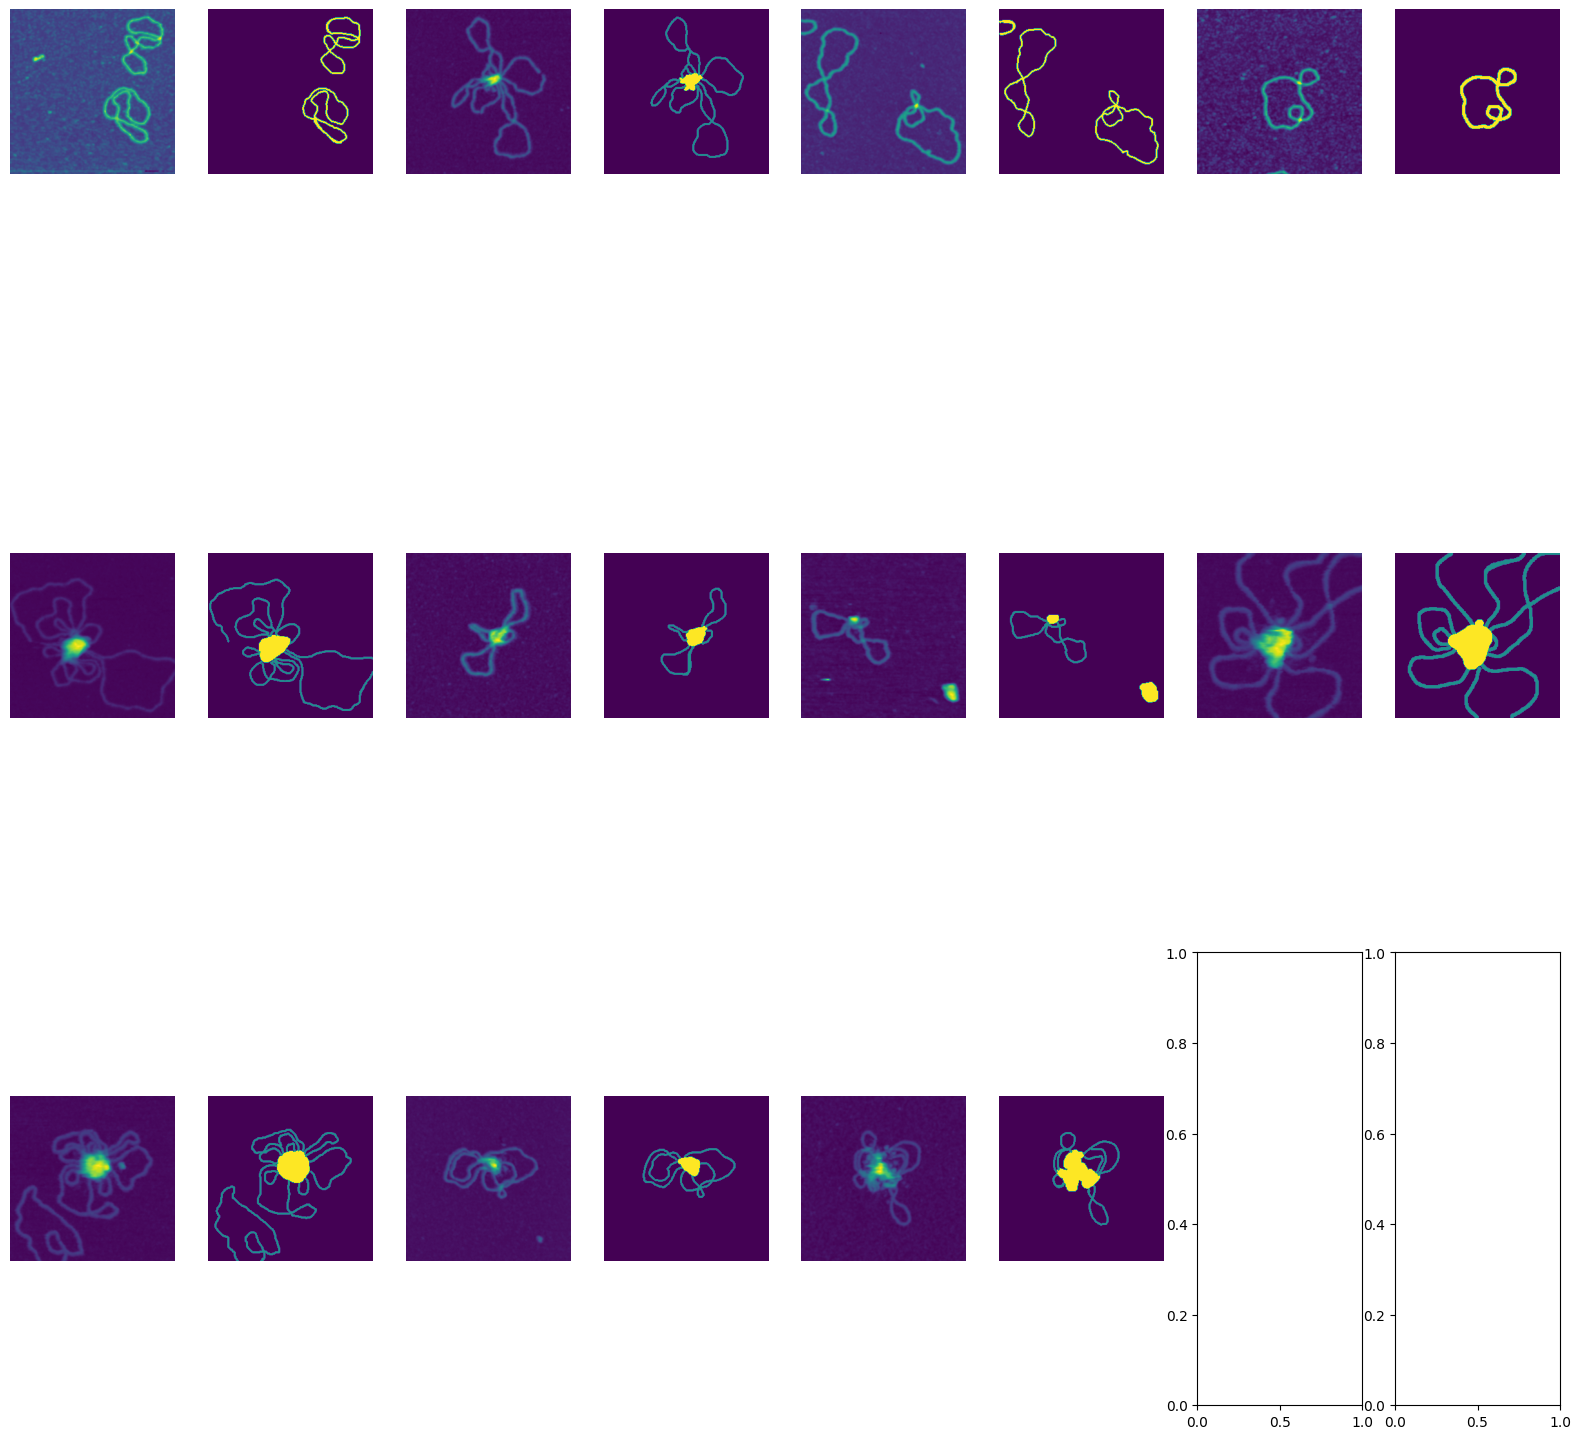

In [4]:
# MacOS
# ORIGINAL_IMAGE_DIR = Path("/Users/sylvi/topo_data/hariborings/training_data/cropped/images/")
# MASK_DIR = Path("/Users/sylvi/topo_data/hariborings/training_data/cropped/multiclass_masks/")

ORIGINAL_IMAGE_DIR = Path(
    "/Users/laura/Desktop/Curated_shelterin/cropped/Training/Images/"
)
MASK_DIR = Path("/Users/laura/Desktop/Curated_shelterin/cropped/Training/Masks/")

# Linux
# ORIGINAL_IMAGE_DIR = Path("/home/sylvia/haribo_data/training_data/cropped/images/")
# MASK_DIR = Path("/home/sylvia/haribo_data/training_data/on_target_labelled")
# Linux Multi Class
# MASK_DIR = Path("/home/sylvia/haribo_data/training_data/cropped/multiclass_masks/")

# Shared XDrive
# MODEL_SAVE_DIR = Path(
#     "/Volumes/shared/pyne_group/Shared/AFM_Data/Cas9_Minicircles/deep_learning/saved_models"
# )
MODEL_SAVE_DIR = Path("/Users/sylvi/topo_data/hariborings/saved_models")

# Get the number of .png images
NUM_IMAGES = len(list(ORIGINAL_IMAGE_DIR.glob("image_*.npy")))
NUM_MASKS = len(list(MASK_DIR.glob("mask_*.npy")))
print(f"Number of images: {NUM_IMAGES}, Number of masks: {NUM_MASKS}")


def plot_images(image_files, mask_files, width=4):
    num_files = len(image_files)
    fig, ax = plt.subplots(np.ceil(num_files / width).astype(int), width * 2, figsize=(20, 20))
    for i, (image_file, mask_file) in enumerate(zip(image_files, mask_files)):
        image = np.load(image_file)
        mask = np.load(mask_file)
        ax[i // width, i % width * 2].imshow(image, cmap="viridis")
        ax[i // width, i % width * 2].axis("off")
        ax[i // width, i % width * 2 + 1].imshow(mask, cmap="viridis")
        ax[i // width, i % width * 2 + 1].axis("off")


plot_images(
    image_files=sorted(list(ORIGINAL_IMAGE_DIR.glob("image_*.npy"))),
    mask_files=sorted(list(MASK_DIR.glob("mask_*.npy"))),
)


In [11]:
def zoom_and_shift(image: np.ndarray, ground_truth: np.ndarray, max_zoom_percentage: float = 0.1) -> np.ndarray:
    """Zooms in on the image by a random amount between 0 and max_zoom_percentage,
    then shifts the image by a random amount up to the number of zoomed pixels.
    """

    # Choose a zoom percentage and caluculate the number of pixels to zoom in
    zoom = np.random.uniform(0, 0.1)
    zoom_pixels = int(image.shape[0] * zoom)

    # If there is zoom, choose a random shift
    if int(zoom_pixels) > 0:
        shift_x = np.random.randint(int(-zoom_pixels), int(zoom_pixels))
        shift_y = np.random.randint(int(-zoom_pixels), int(zoom_pixels))

        # Zoom and shift the image
        zoomed_and_shifted_image = image[
            zoom_pixels + shift_x : -zoom_pixels + shift_x,
            zoom_pixels + shift_y : -zoom_pixels + shift_y,
        ]
        zoomed_and_shifted_ground_truth = ground_truth[
            zoom_pixels + shift_x : -zoom_pixels + shift_x,
            zoom_pixels + shift_y : -zoom_pixels + shift_y,
        ]
    else:
        # Do nothing
        shift_x = 0
        shift_y = 0

        zoomed_and_shifted_image = image
        zoomed_and_shifted_ground_truth = ground_truth

    return zoomed_and_shifted_image, zoomed_and_shifted_ground_truth


# An image generator that loads images as they are needed
import numpy as np
import random
from tensorflow.keras.utils import to_categorical
from pathlib import Path

import numpy as np
import random
import os

def image_generator(image_indexes, batch_size=4, loss="categorical_crossentropy", num_classes=3):
    while True:
        # Check if batch_size is greater than the number of available indices
        num_available = len(image_indexes)
        if num_available < batch_size:
            # Adjust batch_size to the number of available indices
            batch_size = num_available
        
        # Select files (paths/indices) for the batch
        batch_image_indexes = np.random.choice(a=image_indexes, size=batch_size, replace=False)
        batch_input = []
        batch_output = []

        # Load the image and ground truth
        for index in batch_image_indexes:
            try:
                image = np.load(os.path.join(ORIGINAL_IMAGE_DIR, f"image_{index}.npy"))
                ground_truth = np.load(os.path.join(MASK_DIR, f"mask_{index}.npy"))
            except FileNotFoundError:
                print(f"File not found: image_{index}.npy or mask_{index}.npy")
                continue  # Skip this sample and move to the next

            # Normalize the image
            LOWER_LIMIT = -1
            UPPER_LIMIT = 8
            image = np.clip(image, LOWER_LIMIT, UPPER_LIMIT)
            image = (image - LOWER_LIMIT) / (UPPER_LIMIT - LOWER_LIMIT)
            
            # Image augmentation
            if random.choice([0, 1]) == 1:
                image = np.flip(image, axis=1)
                ground_truth = np.flip(ground_truth, axis=1)
            rotation = random.choice([0, 1, 2, 3])
            image = np.rot90(image, rotation)
            ground_truth = np.rot90(ground_truth, rotation)

            # Append to batch
            batch_input.append(image)
            
            # Process ground truth based on loss function
            if loss == "categorical_crossentropy":
                # Handle missing classes by creating masks dynamically
                ground_truth_masks = [(ground_truth == i) for i in range(num_classes)]
                # Stack masks and ensure consistent shape
                ground_truth = np.stack(ground_truth_masks + [np.zeros_like(ground_truth)] * (num_classes - len(ground_truth_masks)), axis=-1)
                batch_output.append(ground_truth)
            elif loss == "dice_loss":
                # Handle missing classes dynamically
                ground_truth_masks = [(ground_truth == i) for i in range(num_classes)]
                ground_truth = np.stack(ground_truth_masks, axis=-1)
                batch_output.append(ground_truth)
            else:
                raise ValueError("Unknown loss function")

        # Ensure batches are of consistent size
        if len(batch_input) < batch_size:
            # Fill in missing samples if the batch is not full
            num_missing = batch_size - len(batch_input)
            batch_input.extend([batch_input[0]] * num_missing)  # Duplicate the first image as placeholder
            batch_output.extend([batch_output[0]] * num_missing)  # Duplicate the first label as placeholder

        batch_x = np.array(batch_input).astype(np.float32)
        batch_y = np.array(batch_output).astype(np.float32)

        yield batch_x, batch_y

In [6]:
CHANNELS = 1
BATCH_SIZE = 5
EPOCHS = 50
AUGMENTATION_FACTOR = 8
LEARNING_RATE = 0.001
LOSS_FUNCTION = "categorical_crossentropy"
IMAGE_SIZE = 256
NUM_CLASSES = 3

mask dtype: float32


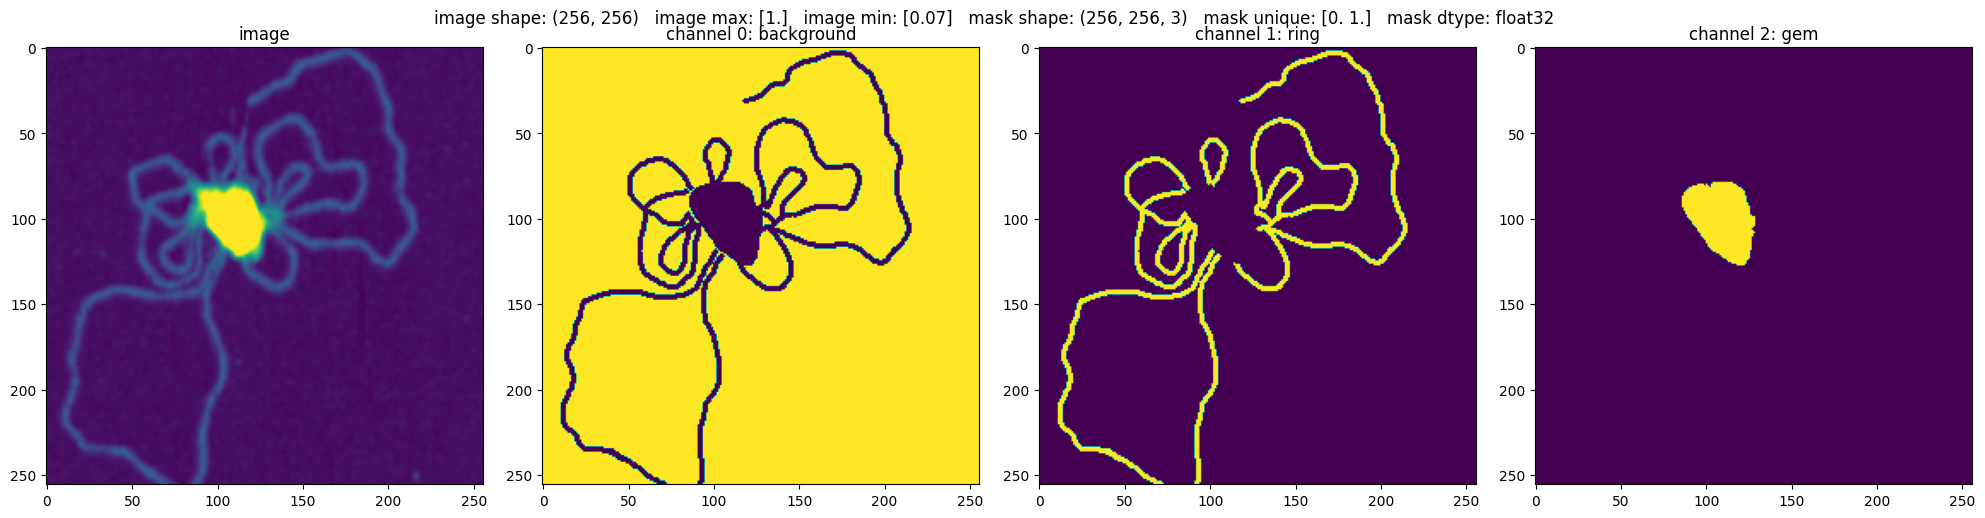

mask dtype: float32


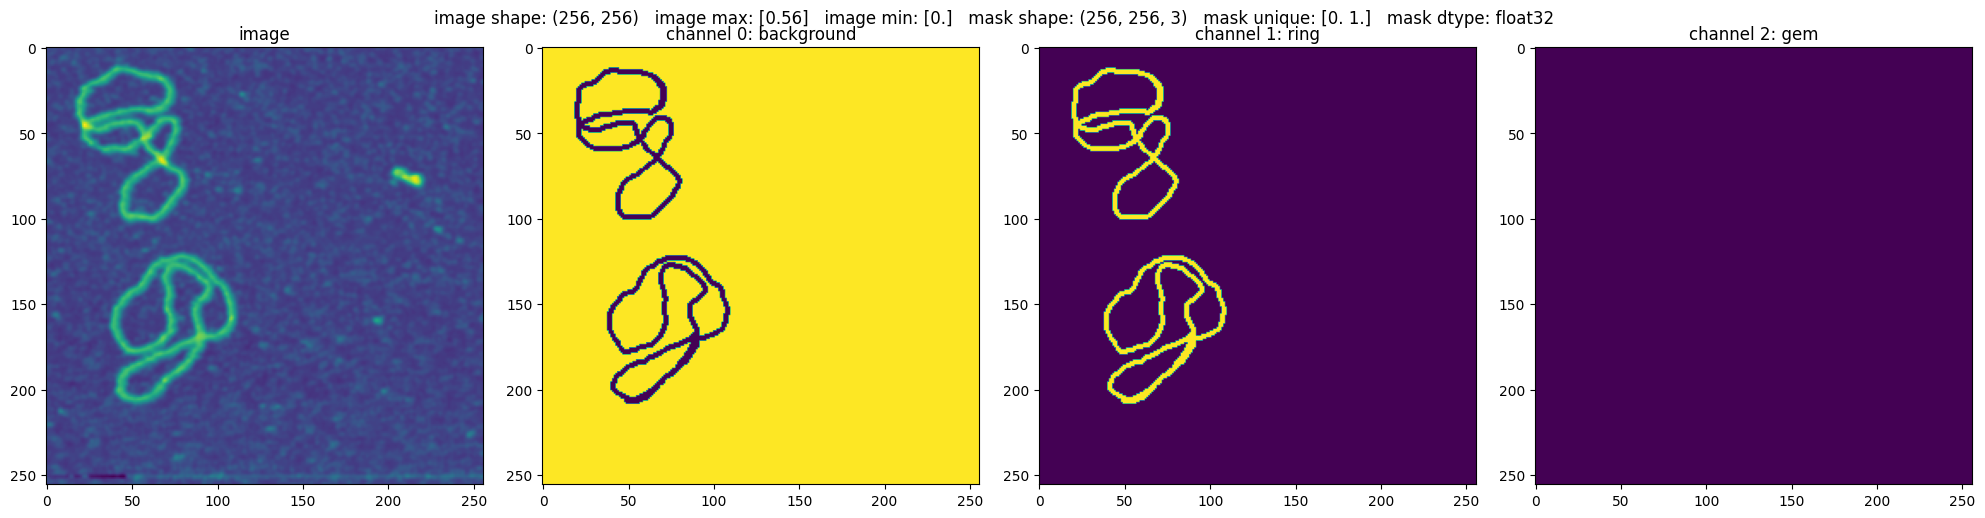

mask dtype: float32


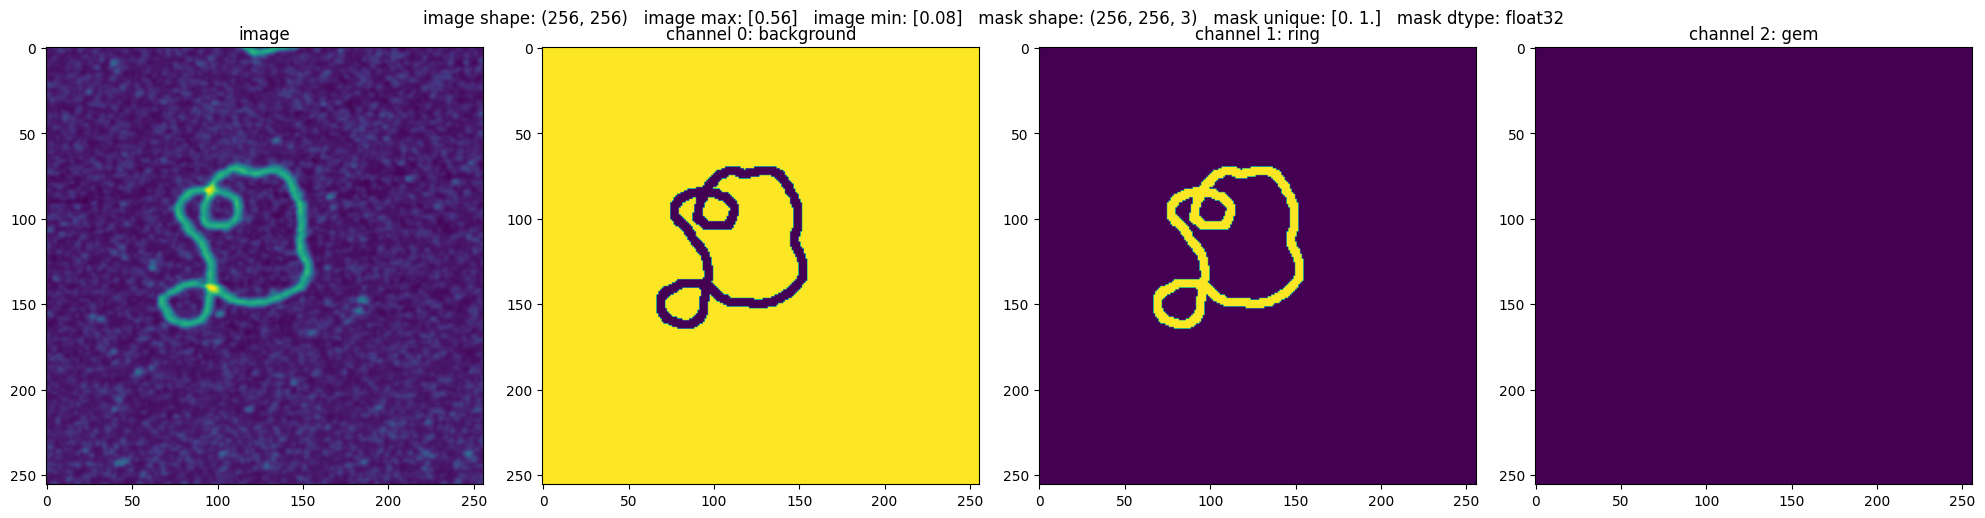

mask dtype: float32


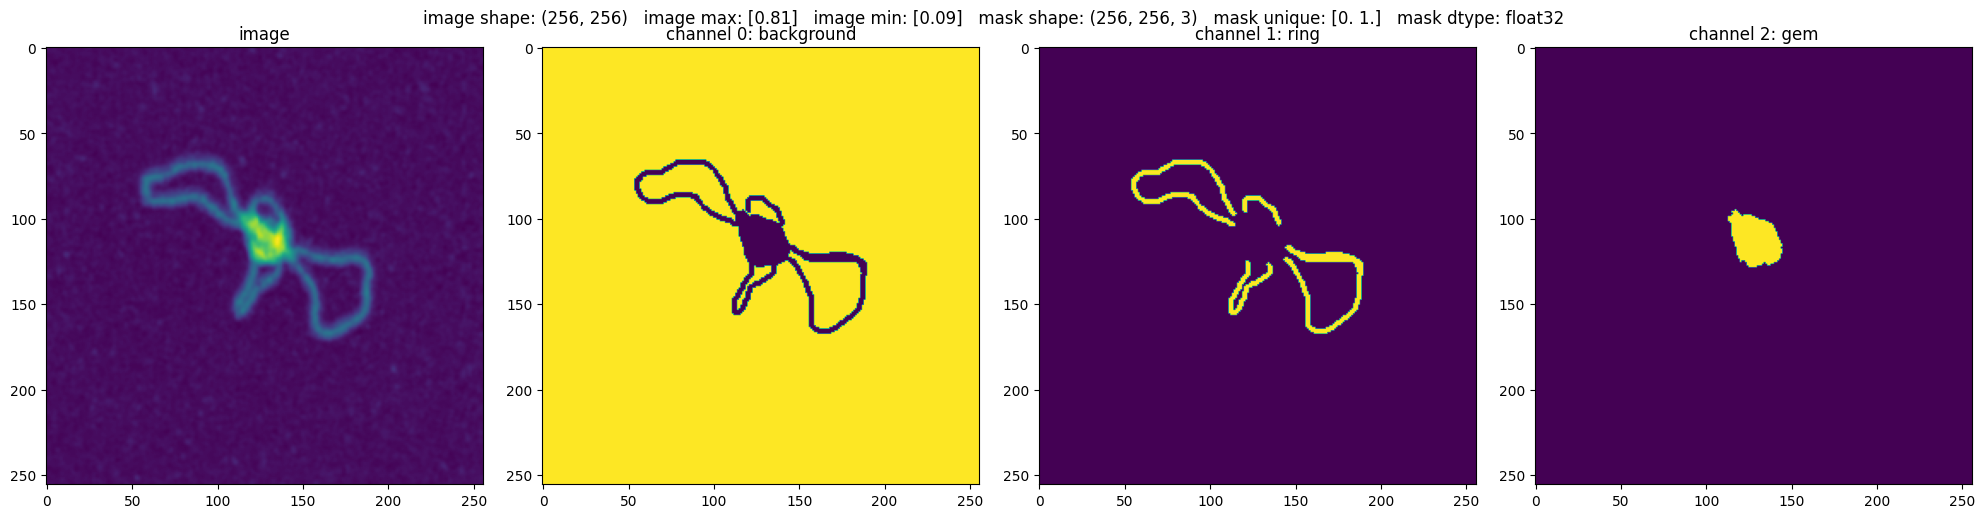

In [12]:
# Check that the generator is doing the right thing
batch_generator = image_generator([1, 2, 3, 4, 5], batch_size=4, loss=LOSS_FUNCTION, num_classes=NUM_CLASSES)
(batch_x, batch_y) = next(batch_generator)
for image, mask in zip(batch_x, batch_y):
    print(f"mask dtype: {mask.dtype}")

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    ax[0].imshow(image)
    ax[0].set_title("image")
    ax[1].imshow(mask[:, :, 0])
    ax[1].set_title("channel 0: background")
    ax[2].imshow(mask[:, :, 1])
    ax[2].set_title("channel 1: ring")
    ax[3].imshow(mask[:, :, 2])
    ax[3].set_title("channel 2: gem")
    fig.suptitle(
        f"image shape: {image.shape}   image max: {np.round([np.max(image)], 2)}   image min: {np.round([np.min(image)],2)}   mask shape: {mask.shape}   mask unique: {np.unique(mask)}   mask dtype: {mask.dtype}"
    )
    fig.tight_layout()
    plt.show()

In [13]:
# Split what images are used for training and validation
train_image_indexes, validation_image_indexes = train_test_split(range(1, NUM_IMAGES + 1), test_size=0.2, random_state=SEED)

print(f"Number of training images: {len(train_image_indexes)}")
print(f"Number of validation images: {len(validation_image_indexes)}")

print(f"Training image indexes: {train_image_indexes}")
print(f"Validation image indexes: {validation_image_indexes}")

# Create the generators
train_generator = image_generator(train_image_indexes, batch_size=4)
validation_generator = image_generator(validation_image_indexes, batch_size=4)

Number of training images: 8
Number of validation images: 3
Training image indexes: [10, 2, 7, 1, 8, 11, 9, 6]
Validation image indexes: [3, 4, 5]


In [9]:
# ===== CREATE THE MODEL =====
model = multiclass_unet_model(
    IMG_HEIGHT=IMAGE_SIZE, IMG_WIDTH=IMAGE_SIZE, IMG_CHANNELS=CHANNELS, learning_rate=LEARNING_RATE
)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,940,851 (7.40 MB)

 Trainable params: 1,940,851 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,940,851 (7.40 MB)

 Trainable params: 1,940,851 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(
    train_generator,
    # How many steps (batches of samples) to draw from generator before declaring one epoch finished and starting the next epoch
    steps_per_epoch=(NUM_IMAGES // BATCH_SIZE) * AUGMENTATION_FACTOR,
    epochs=EPOCHS,
    validation_data=validation_generator,
    # How many steps (batches) to yield from validation generator at the end of every epoch
    validation_steps=(NUM_IMAGES // BATCH_SIZE) * AUGMENTATION_FACTOR,
    verbose=1,
)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 364ms/step - accuracy: 0.9281 - loss: 0.5131 - mean_iou: 5.5697e-05 - val_accuracy: 0.9501 - val_loss: 0.1922 - val_mean_iou: 1.0182e-04
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step - accuracy: 0.9394 - loss: 0.1951 - mean_iou: 6.5423e-05 - val_accuracy: 0.9501 - val_loss: 0.1633 - val_mean_iou: 1.0182e-04
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 349ms/step - accuracy: 0.9301 - loss: 0.1452 - mean_iou: 5.6808e-05 - val_accuracy: 0.9501 - val_loss: 0.1411 - val_mean_iou: 1.0182e-04
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step - accuracy: 0.9319 - loss: 0.1285 - mean_iou: 5.8947e-05 - val_accuracy: 0.9551 - val_loss: 0.1148 - val_mean_iou: 1.0182e-04
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 354ms/step - accuracy: 0.9353 - loss: 0.1249 - mean_iou: 5.5006e-05 - val_accuracy: 0.9615 - val_loss: 0.0974 - val_mean_iou: 1.0182e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step - accuracy: 0.9437 - loss: 0.1126 - mean_iou: 0.0029 - val

dict_keys(['accuracy', 'loss', 'mean_iou', 'val_accuracy', 'val_loss', 'val_mean_iou'])


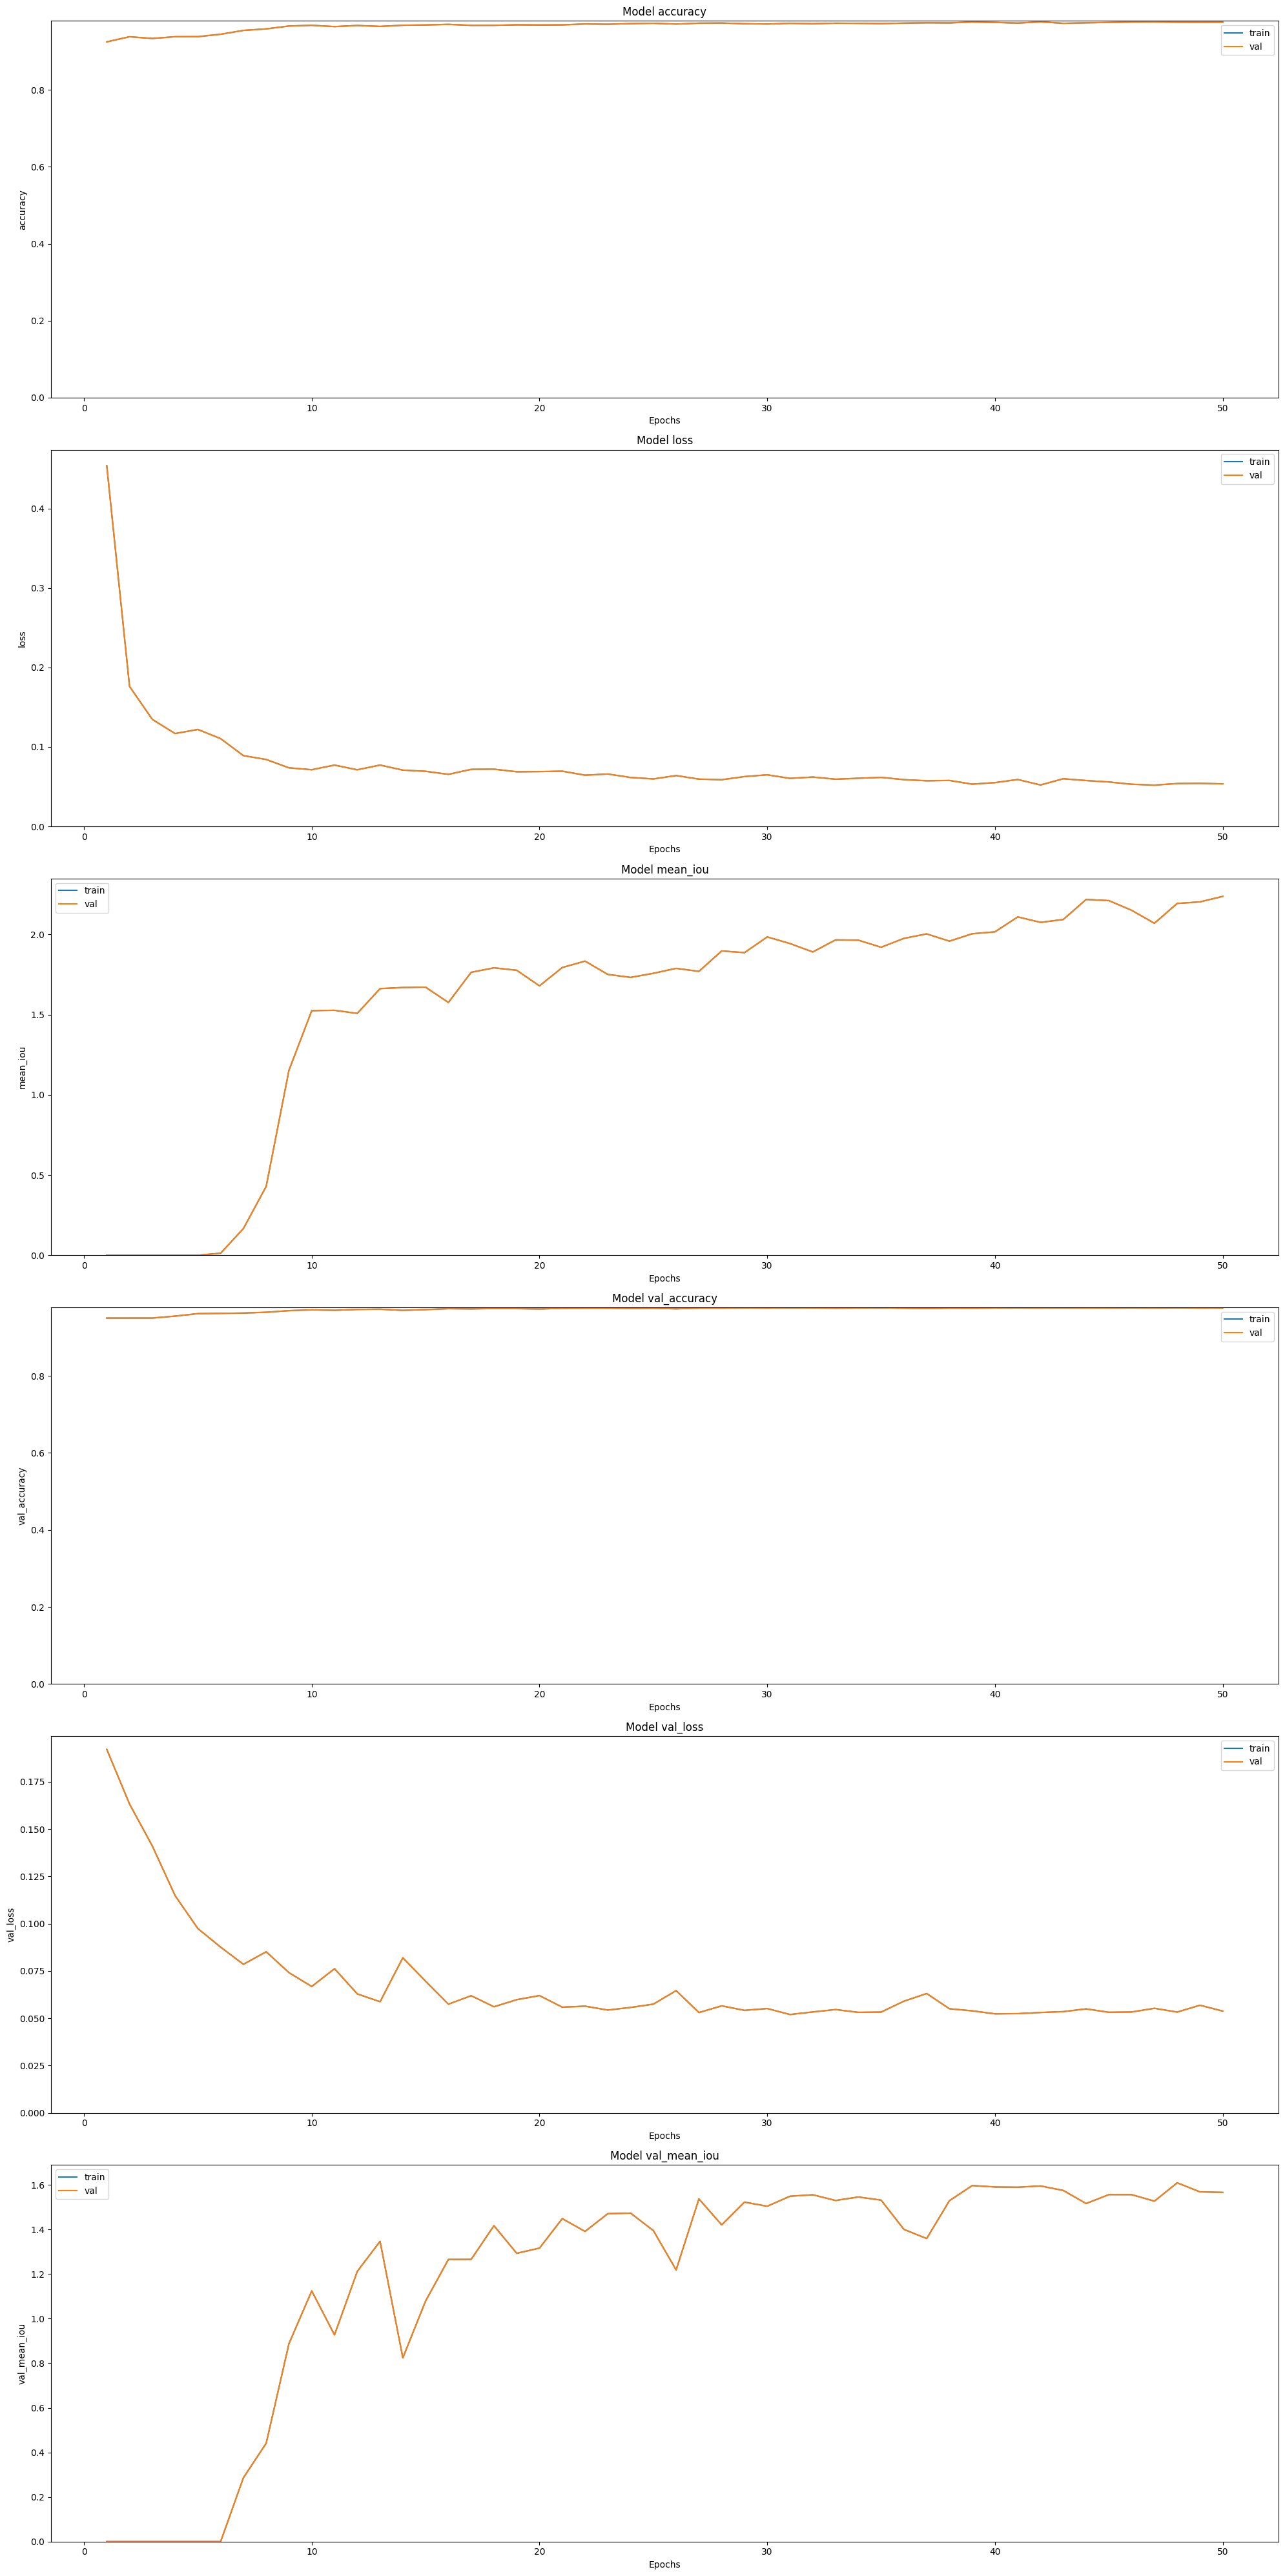

In [15]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)

print(history.history.keys())

# Plot all the metrics
fig, ax = plt.subplots(len(history.history.keys()), 1, figsize=(20, 40))
for i, metric in enumerate(history.history.keys()):
    ax[i].plot(epochs, history.history[metric])
    ax[i].plot(epochs, history.history[f"{metric}"])
    ax[i].set_title(f"Model {metric}")
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])
    ax[i].set_ylim(0, None)

fig.tight_layout()

In [ ]:
# Save the model
model.save(
    MODEL_SAVE_DIR
    / f"haribonet_multiclass_improved_norm_big_95_bridging_v1{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.h5"
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
predicted masks shape: (3, 256, 256, 3)


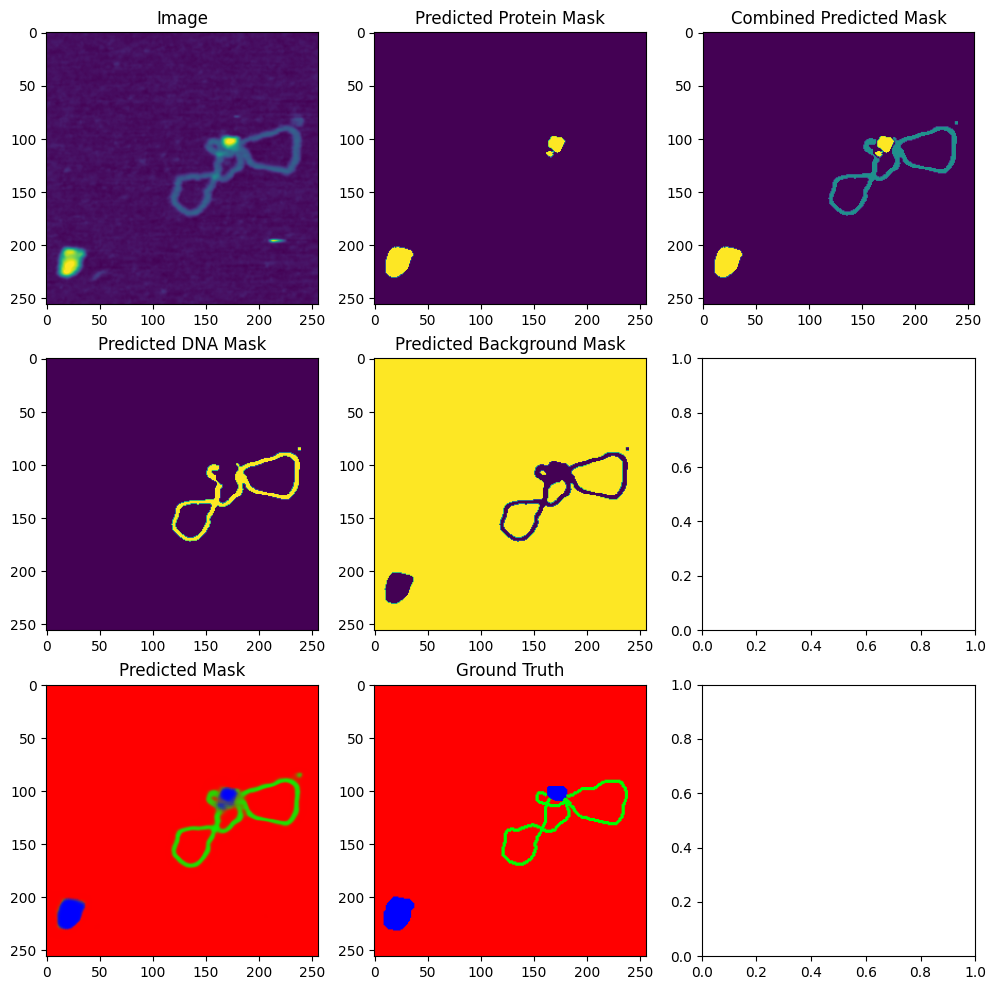

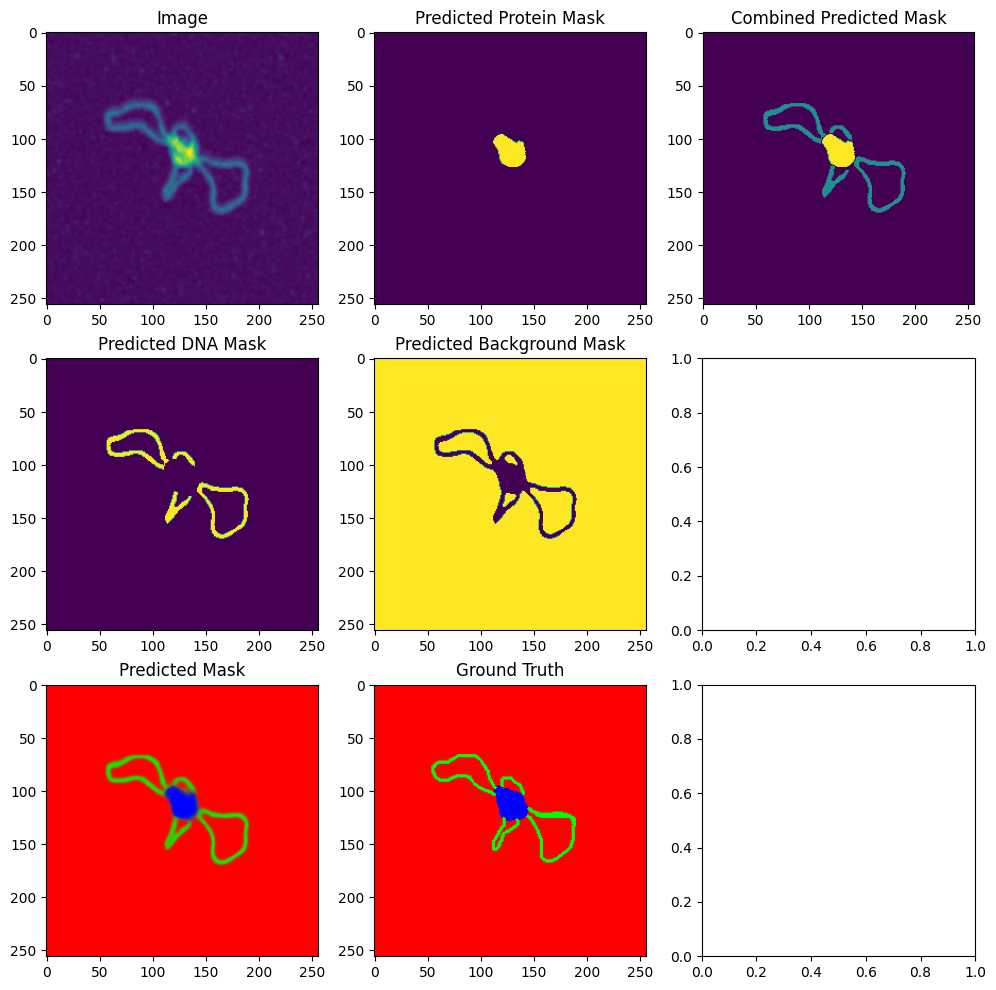

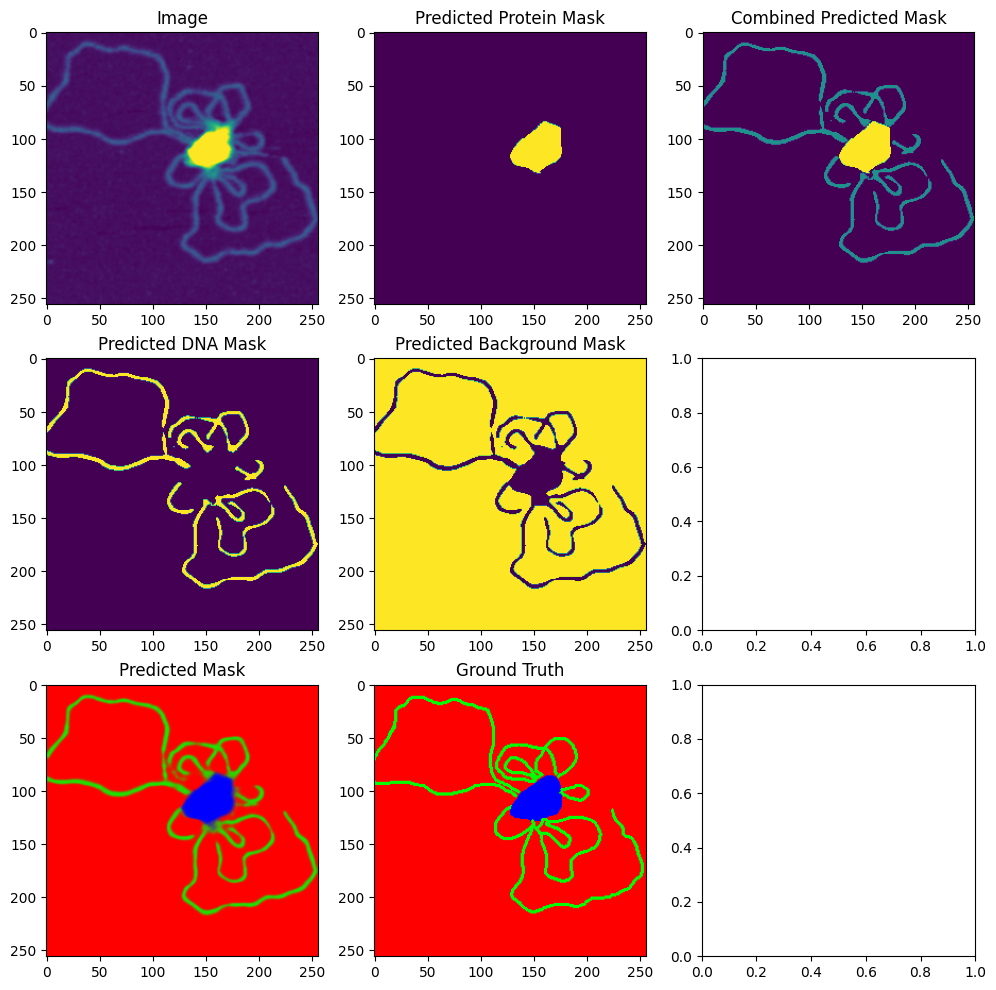

In [18]:
# Show the results of the model on the testing set using the validation generator
# Get the next batch from the generator
(batch_x, batch_y) = next(validation_generator)
# Predict the masks
predicted_masks = model.predict(batch_x)

print(f"predicted masks shape: {predicted_masks.shape}")

# Threshold the masks
# predicted_masks = (predicted_masks > 0.01).astype(np.uint8)
# # Show the results
# for image, mask, predicted_mask in zip(batch_x, batch_y, predicted_masks):
#     plt.imshow(image)
#     plt.show()
#     plt.imshow(mask)
#     plt.show()
#     plt.imshow(predicted_mask)
#     plt.show()

threshold = 0.5

for image, mask, predicted_mask in zip(batch_x, batch_y, predicted_masks):
    # Gem predicted mask
    predicted_gem_mask = predicted_mask[:, :, 2] > threshold
    # Ring predicted mask
    predicted_ring_mask = predicted_mask[:, :, 1] > threshold
    # Background predicted mask
    predicted_background_mask = predicted_mask[:, :, 0] > threshold

    combined_predicted_mask = np.zeros_like(predicted_gem_mask).astype(int)
    combined_predicted_mask[predicted_gem_mask] = 2
    combined_predicted_mask[predicted_ring_mask] = 1

    # plt.imshow(image)
    # plt.title("Image")
    # plt.show()
    # plt.imshow(predicted_gem_mask)
    # plt.title("Predicted Gem Mask")
    # plt.show()
    # plt.imshow(predicted_ring_mask)
    # plt.title("Predicted Ring Mask")
    # plt.show()
    # plt.imshow(predicted_background_mask)
    # plt.title("Predicted Background Mask")
    # plt.show()
    # plt.imshow(predicted_mask)
    # plt.title("Predicted Mask")
    # plt.show()
    # plt.title("Ground Truth")
    # plt.imshow(mask)
    # plt.show()

    # Combine these plots into one figure
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    axs[0, 0].imshow(image)
    axs[0, 0].set_title("Image")
    axs[0, 1].imshow(predicted_gem_mask)
    axs[0, 1].set_title("Predicted Protein Mask")
    axs[1, 0].imshow(predicted_ring_mask)
    axs[1, 0].set_title("Predicted DNA Mask")
    axs[1, 1].imshow(predicted_background_mask)
    axs[1, 1].set_title("Predicted Background Mask")
    axs[2, 0].imshow(predicted_mask)
    axs[2, 0].set_title("Predicted Mask")
    axs[2, 1].imshow(mask)
    axs[2, 1].set_title("Ground Truth")
    axs[0, 2].imshow(combined_predicted_mask)
    axs[0, 2].set_title("Combined Predicted Mask")
    plt.show()

### Load a model

In [ ]:
# Load a model
# ===== LOAD THE MODEL =====

MODEL_SAVE_DIR = Path("/Users/sylvi/topo_data/hariborings/saved_models/")

# List available models
for model in MODEL_SAVE_DIR.glob("*"):
    print(model)

filename = "haribonet_multiclass_2023-10-20_14-01-15_intial_results_multiclass_cropped.h5"
# filename = "haribonet_multiclass_2023-12-15_14-15-45.h5"

model = tf.keras.models.load_model(MODEL_SAVE_DIR / filename)
model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


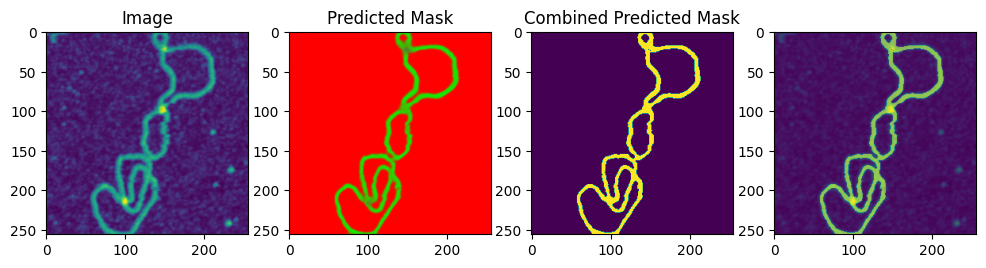

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


<Figure size 640x480 with 0 Axes>

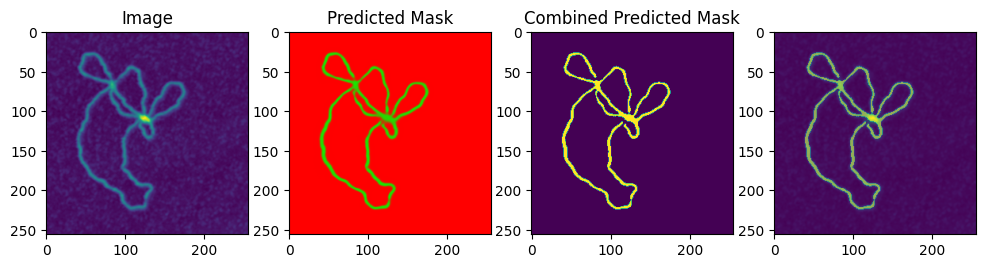

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


<Figure size 640x480 with 0 Axes>

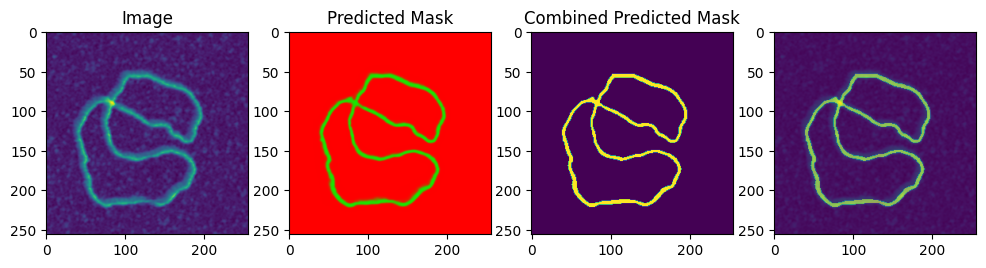

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


<Figure size 640x480 with 0 Axes>

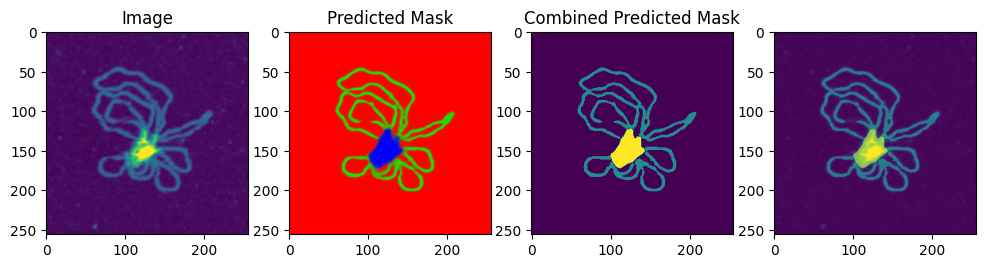

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


<Figure size 640x480 with 0 Axes>

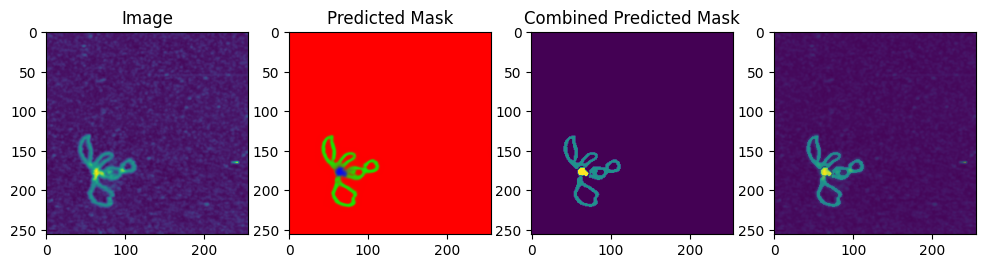

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


<Figure size 640x480 with 0 Axes>

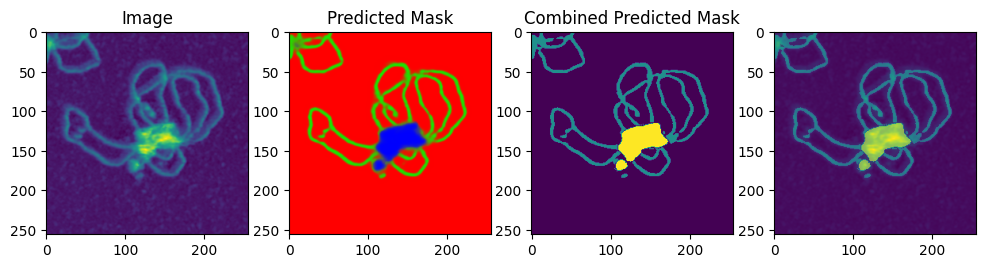

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


<Figure size 640x480 with 0 Axes>

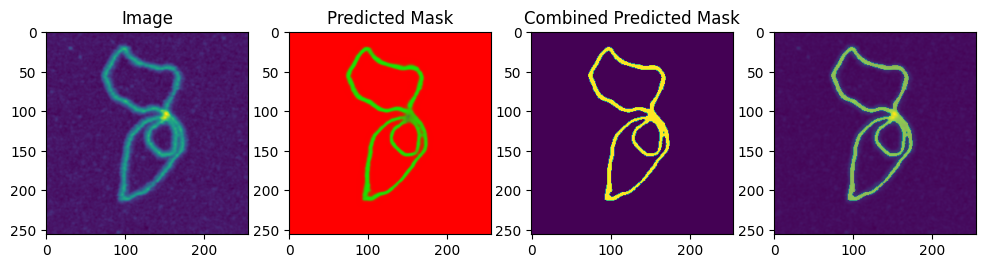

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<Figure size 640x480 with 0 Axes>

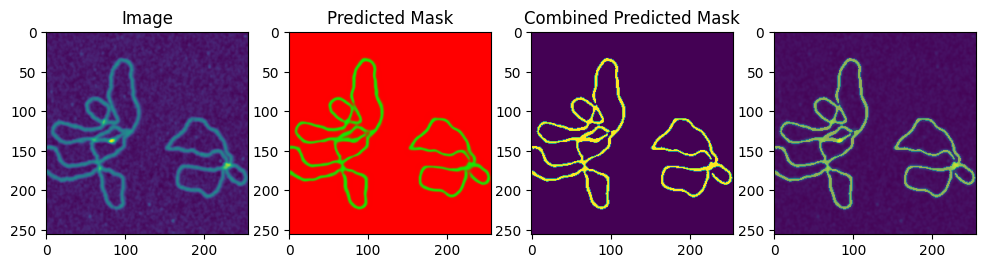

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<Figure size 640x480 with 0 Axes>

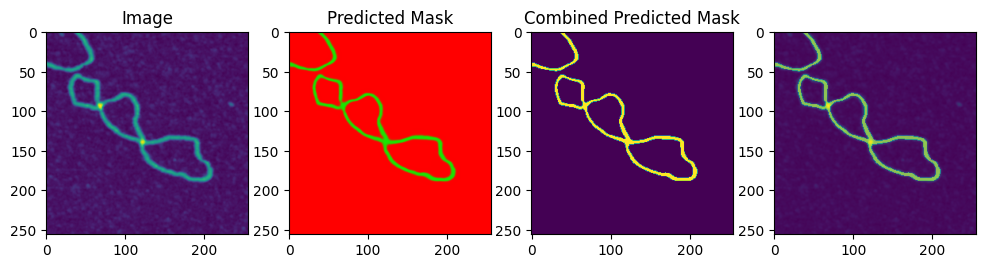

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


<Figure size 640x480 with 0 Axes>

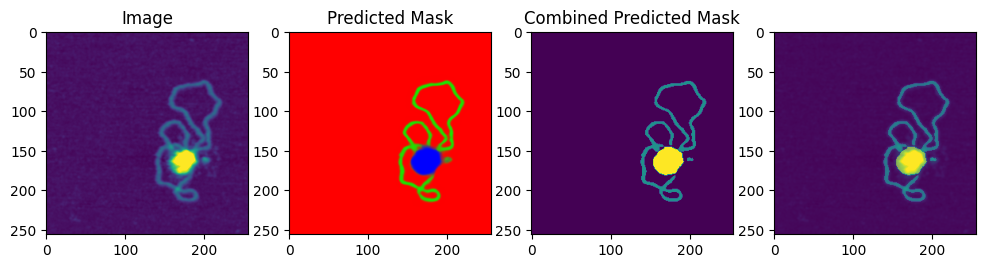

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


<Figure size 640x480 with 0 Axes>

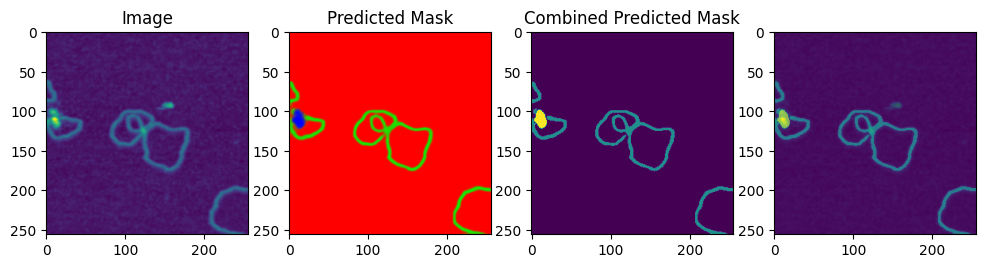

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<Figure size 640x480 with 0 Axes>

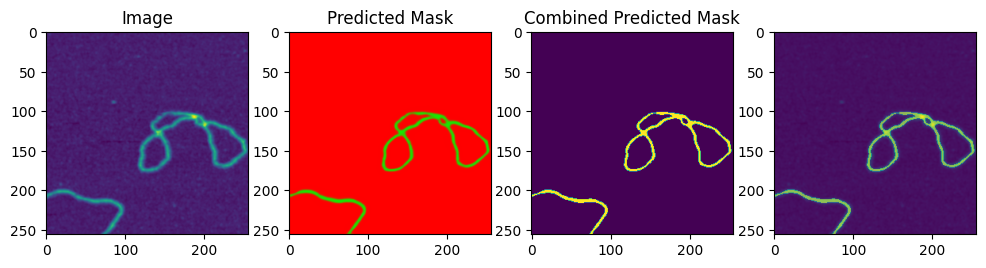

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


<Figure size 640x480 with 0 Axes>

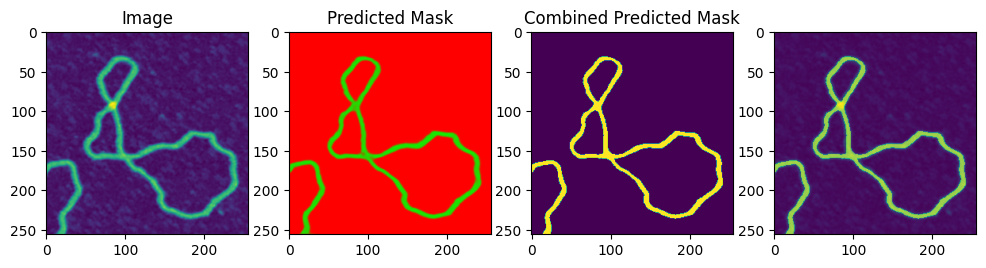

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<Figure size 640x480 with 0 Axes>

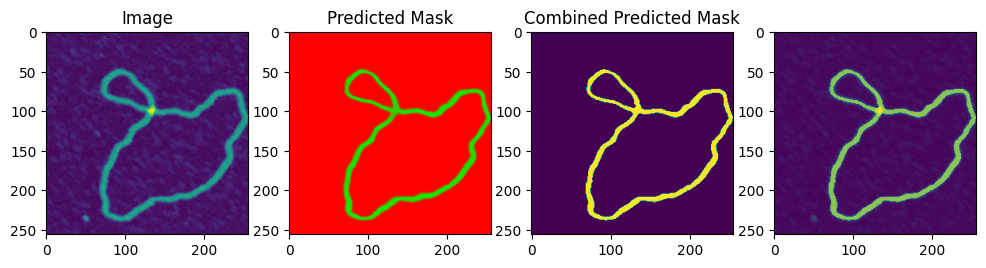

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


<Figure size 640x480 with 0 Axes>

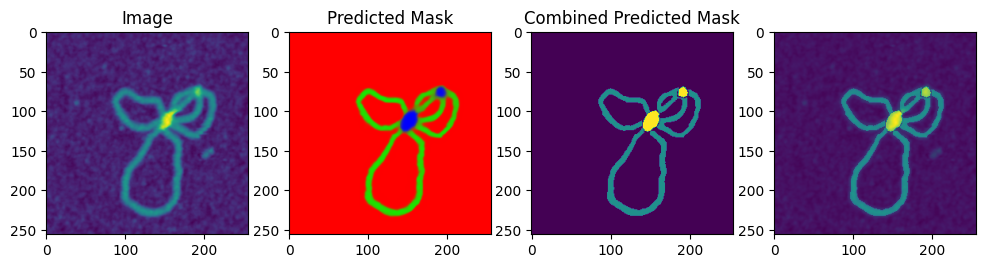

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<Figure size 640x480 with 0 Axes>

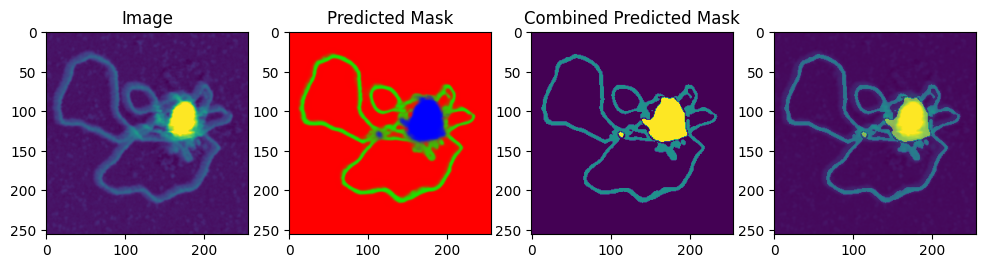

<Figure size 640x480 with 0 Axes>

In [17]:
# Predict images from another directory
PREDICT_DIR = Path("/Users/laura/Desktop/Curated_shelterin/cropped")
files = sorted(list(PREDICT_DIR.glob("*.npy")))
for file in files:
    # image = np.load(ORIGINAL_IMAGE_DIR / f"image_{index}.npy")
    image = np.load(file)
    image = Image.fromarray(image)
    image = image.resize((256, 256))
    image = np.array(image)
    # Normalise the image
    # image = image - np.min(image)
    # image = image / np.max(image)
    LOWER_LIMIT = -1
    UPPER_LIMIT = 8
    image = np.clip(image, LOWER_LIMIT, UPPER_LIMIT)
    image = image - LOWER_LIMIT
    image = image / (UPPER_LIMIT - LOWER_LIMIT)

    # ground_truth = np.load(MASK_DIR / f"mask_{index}.npy")
    # ground_truth = ground_truth.astype(int)
    # ground_truth = Image.fromarray(ground_truth.astype(np.uint8))
    # No interpolation
    # ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
    # ground_truth = np.array(ground_truth).astype(int)

    # Predict the mask
    predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]

    threshold = 0.5

    # Gem predicted mask
    predicted_gem_mask = predicted_mask[:, :, 2] > threshold
    # Ring predicted mask
    predicted_ring_mask = predicted_mask[:, :, 1] > threshold
    # Background predicted mask
    predicted_background_mask = predicted_mask[:, :, 0] > threshold

    combined_predicted_mask = np.zeros_like(predicted_gem_mask).astype(int)
    combined_predicted_mask[predicted_gem_mask] = 2
    combined_predicted_mask[predicted_ring_mask] = 1

    # Plot them side by side
    fig, axs = plt.subplots(1, 4, figsize=(12, 12))
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[1].imshow(predicted_mask)
    axs[1].set_title("Predicted Mask")
    axs[2].imshow(combined_predicted_mask)
    axs[2].set_title("Combined Predicted Mask")
    axs[3].imshow(image)
    axs[3].imshow(combined_predicted_mask, alpha=0.5)
    plt.show()
    plt.savefig(PREDICT_DIR / f"predicted_mask_{file.stem}.png")

In [ ]:
# Get an image from the validation set
index = 1
image = np.load(ORIGINAL_IMAGE_DIR / f"image_{index}.npy")
image = Image.fromarray(image)
image = image.resize((512, 512))
image = np.array(image)
# Normalise the image
image = image - np.min(image)
image = image / np.max(image)

ground_truth = np.load(MASK_DIR / f"mask_{index}.npy")
ground_truth = ground_truth.astype(int)
ground_truth = Image.fromarray(ground_truth.astype(np.uint8))
# No interpolation
ground_truth = ground_truth.resize((512, 512), resample=Image.NEAREST)
ground_truth = np.array(ground_truth).astype(int)

# Predict the mask
predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]


threshold = 0.5

# Gem predicted mask
predicted_gem_mask = predicted_mask[:, :, 2] > threshold
# Ring predicted mask
predicted_ring_mask = predicted_mask[:, :, 1] > threshold
# Background predicted mask
predicted_background_mask = predicted_mask[:, :, 0] > threshold

combined_predicted_mask = np.zeros_like(predicted_gem_mask).astype(int)
combined_predicted_mask[predicted_gem_mask] = 2
combined_predicted_mask[predicted_ring_mask] = 1


# Plot them side by side
fig, axs = plt.subplots(1, 4, figsize=(12, 12))
axs[0].imshow(image)
axs[0].set_title("Image")
axs[1].imshow(ground_truth)
axs[1].set_title("Ground Truth")
axs[2].imshow(predicted_mask)
axs[2].set_title("Predicted Mask")
axs[3].imshow(combined_predicted_mask)
axs[3].set_title("Combined Predicted Mask")
plt.show()


# Remove all but the largest connected component from the mask
# Gem is label as 2
# Ring is labelled as 1
# Background is labelled as 0
# Get the connected components

# Get just the gem mask
gem_mask = combined_predicted_mask == 2
# Get the connected components
gem_mask_components = label(gem_mask)

# Plot the gem mask components with a text label for each component showing the value of the label
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(gem_mask_components)
for region in regionprops(gem_mask_components):
    # Draw rectangle around segmented coins.
    minr, minc, maxr, maxc = region.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax.plot(bx, by, "-r", linewidth=2.5)
    ax.text(
        region.centroid[1],
        region.centroid[0],
        f"{region.label}",
        color="black",
        ha="center",
        va="center",
    )
ax.set_axis_off()
plt.tight_layout()
plt.show()

# Get the properties of the connected components
gem_mask_properties = regionprops(gem_mask_components)
gem_region_with_largest_area = gem_mask_properties[0]
for index, region in enumerate(gem_mask_properties):
    # print(f"Region: {index}, Area: {region.area}")
    if region.area > gem_region_with_largest_area.area:
        gem_region_with_largest_area = region

print(f"Region with largest area: {gem_region_with_largest_area.label}")

# Delete all regions except the largest
# Actually collect the smaller ones for later
smaller_gem_mask_components = np.copy(gem_mask_components)
smaller_gem_mask_components[smaller_gem_mask_components == gem_region_with_largest_area.label] = 0
# Dilate the smaller gem mask components using binary dilation
smaller_gem_component_dilation_iterations = 10
for i in range(smaller_gem_component_dilation_iterations):
    smaller_gem_mask_components = binary_dilation(smaller_gem_mask_components)
plt.imshow(smaller_gem_mask_components)
plt.title("Smaller Gem Mask Components")
plt.show()

gem_mask_components[gem_mask_components != gem_region_with_largest_area.label] = 0

# Get just the ring mask
ring_mask = combined_predicted_mask == 1
# Get the connected components
ring_mask_components = label(ring_mask)
# Get the properties of the connected components
ring_mask_properties = regionprops(ring_mask_components)
ring_region_with_largest_area = ring_mask_properties[0]
for index, region in enumerate(ring_mask_properties):
    # print(f"Region: {index}, Area: {region.area}")
    if region.area > ring_region_with_largest_area.area:
        ring_region_with_largest_area = region

# Delete all regions except the largest
ring_mask_components[ring_mask_components != ring_region_with_largest_area.label] = 0

# Combine the gem and ring masks
combined_mask = np.zeros_like(gem_mask_components)
combined_mask[gem_mask_components > 0] = 2
combined_mask[ring_mask_components > 0] = 1

# Add the smaller gem mask components if they touch the ring mask
for index in np.unique(label(smaller_gem_mask_components)):
    # Skip background
    if index == 0:
        continue

    # Check if the region touches the ring mask using logical and
    # Get the region
    region = label(smaller_gem_mask_components) == index
    # Get the ring mask
    ring_mask = ring_mask_components > 0

    # Overlap
    overlap = np.logical_and(region, ring_mask)
    if overlap.any():
        # If it does, add it to the ring mask part of the combined mask
        combined_mask[region] = 1

    fig, ax = plt.subplots(1, 4, figsize=(10, 6))
    ax[0].imshow(region)
    ax[0].set_title("Region")
    ax[1].imshow(ring_mask)
    ax[1].set_title("Ring Mask")
    ax[2].imshow(overlap)
    ax[2].set_title("Overlap")
    ax[3].imshow(combined_mask)
    ax[3].set_title("Combined Mask")
    plt.show()


# Plot the largest regions
fig, axs = plt.subplots(1, 3, figsize=(12, 12))
axs[0].imshow(gem_mask_components)
axs[0].set_title("Gem largest region")
axs[1].imshow(ring_mask_components)
axs[1].set_title("Ring largest region")
axs[2].imshow(combined_mask)
axs[2].set_title("Combined largest regions")
plt.show()


# Try to determine the two connected parts of the large blob with the "gem" blob. Sometimes there will be more than two distinct points of contact between the two.
# Perhaps separate based on the line connecting the centroids of the gem and ring?

In [ ]:
# Plot combined mask
plt.imshow(combined_mask)
plt.title("Combined Mask")
plt.colorbar()
plt.show()

ring_mask = combined_mask == 1
# Do the dilation multiple times
dilation_strength = 10
for i in range(dilation_strength):
    ring_mask_dilated = binary_dilation(ring_mask)
# Apply the dilation to the combined mask
combined_mask[ring_mask_dilated] = 1

fig, axs = plt.subplots(1, 1, figsize=(20, 20))
axs.imshow(combined_mask)
axs.set_title(f"Combined Mask with {dilation_strength} dilations")
plt.show()

In [ ]:
# Remove small regions of background
background_mask = combined_mask == 0

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(background_mask)
ax.set_title("Background Mask")
plt.show()

# Turn any regions that are smaller than a certain size into 1s
background_mask_components = label(background_mask)
background_mask_components_coloured = label2rgb(background_mask_components)
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(background_mask_components_coloured)
ax.set_title("Background Mask Components")
plt.show()

# Make a copy of the combined mask
combined_mask_ring_expanded = np.copy(combined_mask)

background_mask_properties = regionprops(background_mask_components)
for index, region in enumerate(background_mask_properties):
    # print(f"Region: {index}, Area: {region.area}")
    if region.area < 200:
        # If the region is touching any pixels that are in the ring mask, then set that region to be in the ring mask
        # Get the outline of the region by dilating the region and then subtracting the original region
        region_mask = background_mask_components == region.label
        region_mask_dilated = binary_dilation(region_mask)
        region_outline = np.logical_and(region_mask_dilated, np.invert(region_mask))
        # Get the pixels in the outline from the combined mask
        region_outline_pixel_values = combined_mask[region_outline]
        # print(f'region outline pixel values: {region_outline_pixel_values[0:10]}')
        # If any of the pixels in the outline are in the ring mask (ie are 1s) then set the region to be in the ring mask
        # Check if there are any pixels with value 1 in the outline
        if np.any(region_outline_pixel_values == 1):
            # Set the region to be in the ring mask
            combined_mask_ring_expanded[background_mask_components == region.label] = 1
        else:
            # Set the region to be in the gem mask
            combined_mask_ring_expanded[background_mask_components == region.label] = 2

plt.imshow(background_mask)
plt.title("Background Mask")
plt.colorbar()
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(combined_mask_ring_expanded)
ax.set_title("combined mask ring expanded")
plt.show()

ring_only = combined_mask_ring_expanded == 1
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(ring_only)
ax.set_title("Ring Only")
plt.show()

# Get distance transform of the ring only mask
distance_transform = distance_transform_edt(ring_only)
plt.imshow(distance_transform)
plt.colorbar()
plt.title("Distance Transform")
plt.show()

In [ ]:
# Take the gem mask and dilate it
gem_mask = combined_mask == 2
near_gem_ring_dilation_strength = 5
gem_mask_dilated = np.copy(gem_mask)
for i in range(near_gem_ring_dilation_strength):
    gem_mask_dilated = binary_dilation(gem_mask_dilated)

# Find the pixels in the dilation that are also in the ring mask
near_gem_and_ring = np.logical_and(gem_mask_dilated, ring_mask)

fig, axs = plt.subplots(3, 1, figsize=(60, 20))
axs[0].imshow(gem_mask)
axs[0].set_title("Gem Mask")
axs[1].imshow(gem_mask_dilated)
axs[1].set_title("Gem Mask Dilated")
axs[2].imshow(near_gem_and_ring)
axs[2].set_title("Touching Ring Mask")
plt.show()

# # Use distance transform from scipy to get distances from the gem mask
# from scipy.ndimage import distance_transform_edt

# distance_threshold = 5

# # Get pixels near the gem mask
# gem_mask = combined_mask == 2
# distance_transform = distance_transform_edt(np.invert(gem_mask))

# plt.imshow(distance_transform)
# plt.colorbar()
# plt.title("Gem Inverted Distance Transform")
# plt.show()

# near_gem = np.logical_and(distance_transform < distance_threshold, distance_transform > 0)
# plt.imshow(near_gem)
# plt.colorbar()
# plt.title(f"Near Gem threshold: {distance_threshold}")
# plt.show()

# # Get the pixels near the ring mask
# ring_mask = combined_mask == 1
# distance_transform = distance_transform_edt(np.invert(ring_mask))

# plt.imshow(distance_transform)
# plt.colorbar()
# plt.title("Ring Inverted Distance Transform")
# plt.show()

# near_ring = np.logical_and(distance_transform < distance_threshold, distance_transform > 0)
# plt.imshow(near_ring)
# plt.colorbar()
# plt.title(f"Near Ring threshold: {distance_threshold}")
# plt.show()

# # Plot both near the gem and ring
# near_gem_or_ring = np.zeros_like(combined_mask)
# near_gem_or_ring[near_gem] += 1
# near_gem_or_ring[near_ring] += 1
# plt.imshow(near_gem_or_ring)
# plt.colorbar()
# plt.title(f"Near Gem or Ring. Threshold: {distance_threshold}")
# plt.show()

# # Get the pixels both near the gem and ring
# near_gem_and_ring = np.logical_and(near_gem, near_ring)
# plt.imshow(near_gem_and_ring)
# plt.colorbar()
# plt.title(f"Near both Gem and Ring. Threshold: {distance_threshold}")
# plt.show()

In [ ]:
## Find the midpoint of each of the two intersection regions

# Cluster the points into two groups, one for each intersection region
# Use the k-means algorithm to cluster the points into two groups
from sklearn.cluster import KMeans

# Get the coordinates of the points
coordinates = np.argwhere(near_gem_and_ring)
# Cluster the points
kmeans = KMeans(n_clusters=2, random_state=0).fit(coordinates)
# Get mask of each cluster
cluster1_mask = kmeans.labels_ == 0
cluster2_mask = kmeans.labels_ == 1
# Plot the clusters
plt.scatter(coordinates[cluster1_mask, 0], coordinates[cluster1_mask, 1], c="red")
plt.scatter(coordinates[cluster2_mask, 0], coordinates[cluster2_mask, 1], c="blue")
plt.title("K-Means Clustering")
plt.show()

# For each cluster:
centroid_1 = np.mean(coordinates[cluster1_mask, :], axis=0)
centroid_2 = np.mean(coordinates[cluster2_mask, :], axis=0)

# Find the closest point in the other cluster to each centroid
# Get the coordinates of each cluster
cluster1_coordinates = coordinates[cluster1_mask, :]
# Get the distance between each point in cluster 1 and the centroid of cluster 1
distances_1 = np.linalg.norm(cluster1_coordinates - centroid_1, axis=1)
# Get the index of the closest point
closest_point_index_1 = np.argmin(distances_1)
# Get the coordinates of the closest point
closest_point_1 = cluster1_coordinates[closest_point_index_1, :]
centroid_1 = closest_point_1

# Get the coordinates of each cluster
cluster2_coordinates = coordinates[cluster2_mask, :]
# Get the distance between each point in cluster 2 and the centroid of cluster 2
distances_2 = np.linalg.norm(cluster2_coordinates - centroid_2, axis=1)
# Get the index of the closest point
closest_point_index_2 = np.argmin(distances_2)
# Get the coordinates of the closest point
closest_point_2 = cluster2_coordinates[closest_point_index_2, :]
centroid_2 = closest_point_2

# Plot the centroids with the cluster
plt.imshow(near_gem_and_ring)
plt.scatter(centroid_1[1], centroid_1[0], c="red")
plt.scatter(centroid_2[1], centroid_2[0], c="blue")
plt.title("Centroid")
plt.show()

In [ ]:
# Create a distance transform of the ring mask
from scipy.ndimage import distance_transform_edt

distance_transform = distance_transform_edt(ring_mask)

# Overlay the centroids on the distance transform beside the combined mask
fig, axs = plt.subplots(1, 2, figsize=(5, 10))
axs[0].imshow(distance_transform)
axs[0].scatter(centroid_1[1], centroid_1[0], c="red")
axs[0].scatter(centroid_2[1], centroid_2[0], c="blue")
axs[0].set_title("Distance Transform")
axs[1].imshow(combined_mask)
axs[1].scatter(centroid_1[1], centroid_1[0], c="red")
axs[1].scatter(centroid_2[1], centroid_2[0], c="blue")
axs[1].set_title("Combined Mask")
plt.show()

In [ ]:
# Invert the distance transform to be used as a weight map, so that the pathfinding algorithm will prefer paths that are closer to the ring
distance_transform_inverted = np.max(distance_transform) - distance_transform
plt.imshow(distance_transform_inverted)
plt.colorbar()
plt.title("Inverted Distance Transform")
plt.show()

# Use a weighted pathfinding algorithm to find the best path between the two centroids,
# with the distance transform as the weight map
from skimage.graph import route_through_array

# Get the path
path, weight = route_through_array(distance_transform_inverted, centroid_1, centroid_2, fully_connected=True)

path = np.stack(path, axis=-1)

print(f"weight: {weight}")

# Plot the path
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
axs[0].imshow(distance_transform_inverted)
axs[0].scatter(centroid_1[1], centroid_1[0], c="red")
axs[0].scatter(centroid_2[1], centroid_2[0], c="blue")
axs[0].plot(path[1], path[0], linewidth=2, c="pink")
axs[0].set_title("Distance Transform")
axs[1].imshow(combined_mask)
axs[1].scatter(centroid_1[1], centroid_1[0], c="red")
axs[1].scatter(centroid_2[1], centroid_2[0], c="blue")
axs[1].plot(path[1], path[0], linewidth=2, c="pink")
axs[1].set_title("Combined Mask")
axs[2].imshow(image)
axs[2].plot(path[1], path[0], linewidth=2, c="pink")
axs[2].set_title("Original Image")
plt.show()